In [37]:
import os
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from utils.config import TOPIC_KEYWORDS, BASE_MODEL_NAME

In [39]:
IG_ROOT = os.path.join("checkpoints/ig", BASE_MODEL_NAME)
OUT_ROOT = "checkpoints/ig_trends"
TOPIC_DIR = "checkpoints/topics"

In [104]:
YEARS = list(range(2015, 2025))
TOP_K_FOR_PLOT = 10
TOP_N_PER_YEAR = 10
RANK_CUTOFF_FOR_PLOT = 12

print("Topics:", list(TOPIC_KEYWORDS.keys()))
print("Years:", YEARS)

Topics: ['racism', 'police', 'immigration']
Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [72]:
def load_ig_for_topic_year(topic: str, year: int, min_count = 8):
    path = os.path.join(IG_ROOT, f"{topic}_{year}_token_attributions.csv")
    if not os.path.isfile(path):
        print(f"[WARN] IG file not found: {path}")
        return None
    df = pd.read_csv(path)
    df = df[df["count"] > min_count]
    df = df.sort_values("avg_attr", ascending=False).reset_index(drop=True)
    return df


In [97]:
def build_rankings_for_side(topic: str, side: str, min_count = 8):
    assert side in ("cnn", "fox")

    yearly_lists = {}
    years_with_data = []

    for year in YEARS:
        df = load_ig_for_topic_year(topic, year, min_count)
        if df is None or df.empty:
            continue

        if side == "cnn":
            df_side = df[df["avg_attr"] > 0.05].sort_values("avg_attr", ascending=False)
        else:  # fox
            df_side = df[df["avg_attr"] < 0.05].sort_values("avg_attr", ascending=True)

        if df_side.empty:
            continue

        top_tokens = df_side["token"].head(TOP_N_PER_YEAR * 5).tolist()

        yearly_lists[year] = top_tokens
        years_with_data.append(year)

    years_with_data.sort()
    return years_with_data, yearly_lists


In [98]:
def build_vocabulary_from_yearly_lists(yearly_lists):
    from collections import defaultdict

    token_years = defaultdict(set)  # token -> set(years)

    for year, tokens in yearly_lists.items():
        for tok in set(tokens):
            token_years[tok].add(year)

    vocab = {tok for tok, yrs in token_years.items() if len(yrs) >= 2}
    return vocab, token_years

In [105]:
EXCLUDE_TOKENS = {
    "##z", "##gb", "##oney", "##ome", "&", "gban", "gfin",
    "gdrugs", "gtik", "gparents", "ginteresting", "gstands",
}

def has_consecutive_years(year_list: list[int]) -> bool:
    """判断这个 token 是否在至少一对连续年份中都出现过。"""
    if len(year_list) < 2:
        return False
    year_list = sorted(set(year_list))
    for i in range(len(year_list) - 1):
        if year_list[i+1] == year_list[i] + 1:
            return True
    return False


def select_top_tokens_for_plot(
    vocab: set[str],
    token_years: dict[str, list[int]],
    yearly_lists: dict[int, list[str]],
    last_year: int,
    rank_cutoff: int = 10,
    min_years: int = 2,
) -> list[str]:
    last_year_top = yearly_lists.get(last_year, [])[:rank_cutoff]
    last_year_top = [t for t in last_year_top if t not in EXCLUDE_TOKENS]

    selected = set()

    for tok in vocab:
        if tok in EXCLUDE_TOKENS:
            continue
        years_for_tok = token_years.get(tok, [])
        if has_consecutive_years(years_for_tok):
            selected.add(tok)

    selected_tokens = sorted(selected)
    return selected_tokens


In [106]:
def build_rank_matrix(years, yearly_lists, tokens_for_plot):
    data = {}
    for tok in tokens_for_plot:
        ranks = []
        for y in years:
            tokens = yearly_lists.get(y, [])
            if tok in tokens:
                rank = tokens.index(tok) + 1
                if rank <= RANK_CUTOFF_FOR_PLOT:
                    ranks.append(rank)
                else:
                    ranks.append(RANK_CUTOFF_FOR_PLOT + 1)
            else:
                ranks.append(RANK_CUTOFF_FOR_PLOT + 1)
        data[tok] = ranks

    df_rank = pd.DataFrame(data, index=years)
    return df_rank


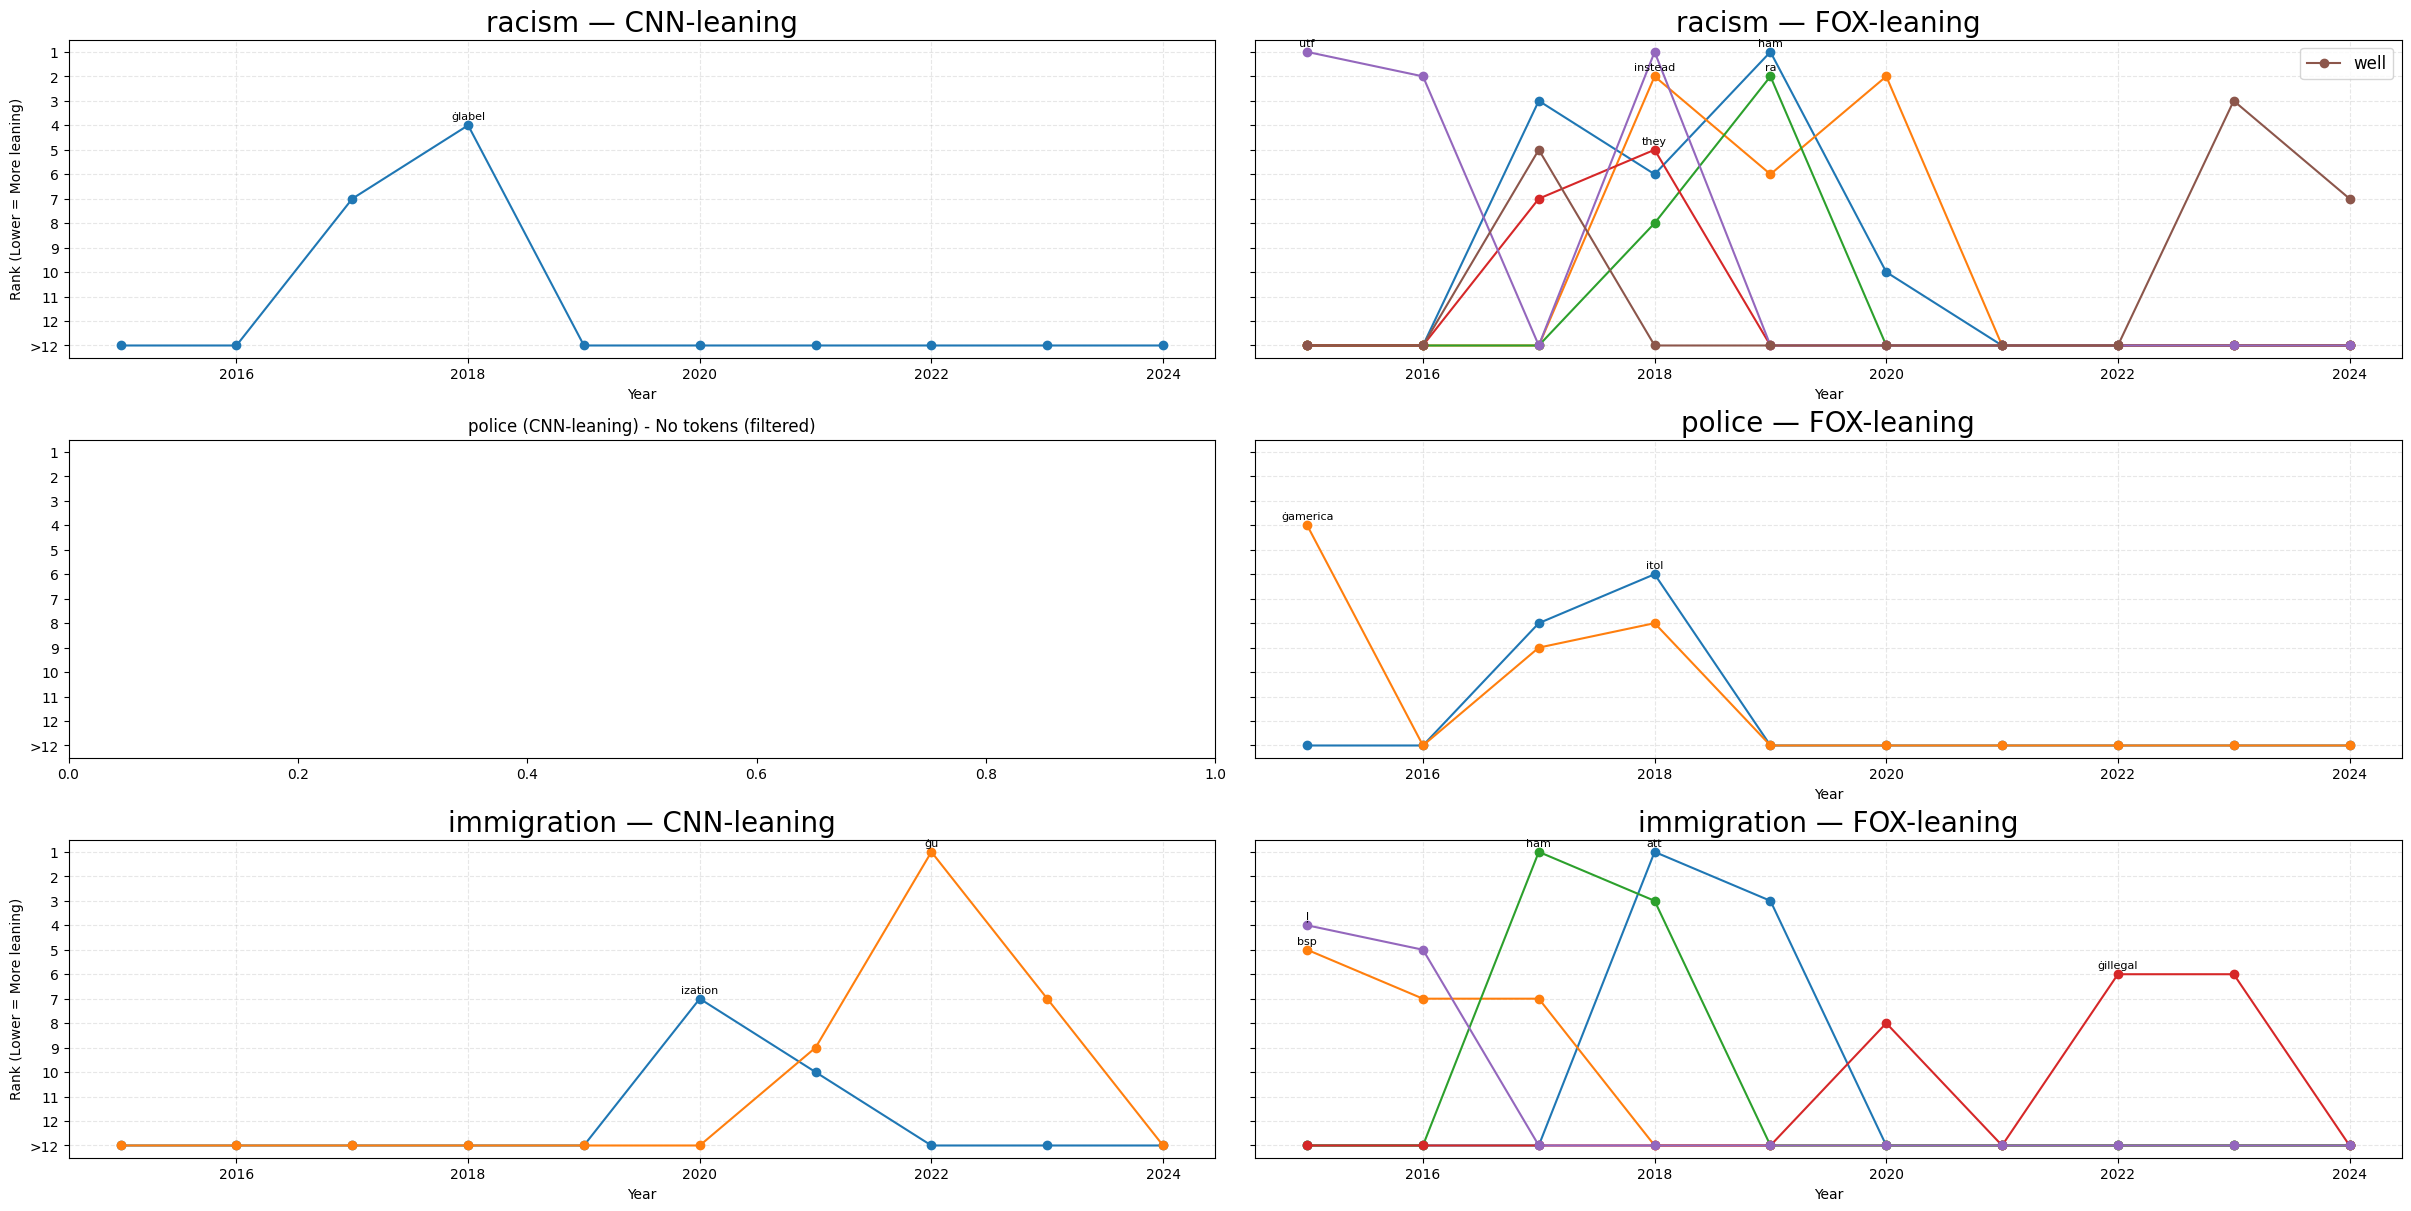

[DONE] saved 3x2 trends figure → figures/trends/study2_topic_rank_trends.png


In [107]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(24, 12),
    sharex=False,
    sharey=True,
    constrained_layout=True
)

sides = ["cnn", "fox"]
side_titles = ["CNN-leaning", "FOX-leaning"]
min_count = 10

for col_idx, side in enumerate(sides):
    for row_idx, topic in enumerate(TOPIC_KEYWORDS.keys()):

        ax = axes[row_idx][col_idx]

        years, yearly_lists = build_rankings_for_side(topic, side, min_count)
        if not years:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No data")
            continue

        vocab, token_years = build_vocabulary_from_yearly_lists(yearly_lists)
        if not vocab:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No tokens")
            continue

        last_year = 2024
        last_year_tokens = yearly_lists.get(last_year, [])[:RANK_CUTOFF_FOR_PLOT]
        last_year_tokens_set = set(last_year_tokens)

        tokens_for_plot = select_top_tokens_for_plot(
            vocab, token_years, yearly_lists, last_year
        )
        if not tokens_for_plot:
            ax.set_title(f"{topic} ({side_titles[col_idx]}) - No tokens (filtered)")
            continue

        df_rank = build_rank_matrix(years, yearly_lists, tokens_for_plot)

        legend_lines = []
        legend_labels = []

        for tok in tokens_for_plot:
            y = df_rank[tok].values
            line, = ax.plot(
                years,
                y,
                marker="o",
                linestyle="-",
            )

            if tok in last_year_tokens_set:
                legend_lines.append(line)
                legend_labels.append(tok)
            else:
                ranks = df_rank[tok].values
                best_idx = ranks.argmin()
                best_year = years[best_idx]
                best_rank = ranks[best_idx]

                ax.text(
                    best_year,
                    best_rank - 0.15,
                    tok,
                    fontsize=8,
                    ha="center",
                    va="bottom",
                )

        ax.invert_yaxis()
        ax.set_ylim(RANK_CUTOFF_FOR_PLOT + 1.5, 0.5)

        ax.set_title(f"{topic} — {side_titles[col_idx]}", fontsize=20)
        ax.set_xlabel("Year")
        if col_idx == 0:
            ax.set_ylabel("Rank (Lower = More leaning)")

        ax.set_yticks(
            list(range(1, RANK_CUTOFF_FOR_PLOT + 1)) + [RANK_CUTOFF_FOR_PLOT + 1]
        )
        ax.set_yticklabels(
            [str(i) for i in range(1, RANK_CUTOFF_FOR_PLOT + 1)] + [f">{RANK_CUTOFF_FOR_PLOT}"]
        )

        if legend_lines:
            ax.legend(legend_lines, legend_labels, loc="upper right", fontsize=12)

        ax.grid(True, linestyle="--", alpha=0.3)

os.makedirs("figures/trends", exist_ok=True)
out_path = "figures/trends/study2_topic_rank_trends.png"
plt.savefig(out_path, dpi=200)

plt.show()

print(f"[DONE] saved 3x2 trends figure → {out_path}")


## dataset observations

In [46]:
def count_words(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(text.split())


def load_topic_year_words(topic: str, year: int):
    fname = f"topic_{topic}_{year}.csv"
    path = os.path.join(TOPIC_DIR, fname)
    if not os.path.isfile(path):
        print(f"[WARN] file not found: {path}")
        return None

    df = pd.read_csv(path)
    if df.empty:
        return None

    assert {"network", "sentence"}.issubset(df.columns)

    df["word_count"] = df["sentence"].apply(count_words)
    agg = df.groupby("network")["word_count"].sum()
    return agg


records = []

for topic in TOPIC_KEYWORDS.keys():
    for year in YEARS:
        agg = load_topic_year_words(topic, year)
        if agg is None:
            continue
        for network, wcount in agg.items():
            records.append(
                {
                    "topic": topic,
                    "year": year,
                    "network": network,
                    "word_count": wcount,
                }
            )

stats_df = pd.DataFrame(records)
stats_df


,topic,year,network,word_count
0,racism,2015,cnn,96769
1,racism,2015,fox,9411
2,racism,2016,cnn,163943
3,racism,2016,fox,8887
4,racism,2017,cnn,88271
5,racism,2017,fox,16356
6,racism,2018,cnn,156636
7,racism,2018,fox,35437
8,racism,2019,cnn,261451
9,racism,2019,fox,70855


In [47]:
def format_millions(x):
    return f"{x / 1_000:.1f}K"


[  9411   8887  16356  35437  70855  48784 125818  48131  12216   4164] [ 96769 163943  88271 156636 261451 214120 156119  88667  78810  81533]


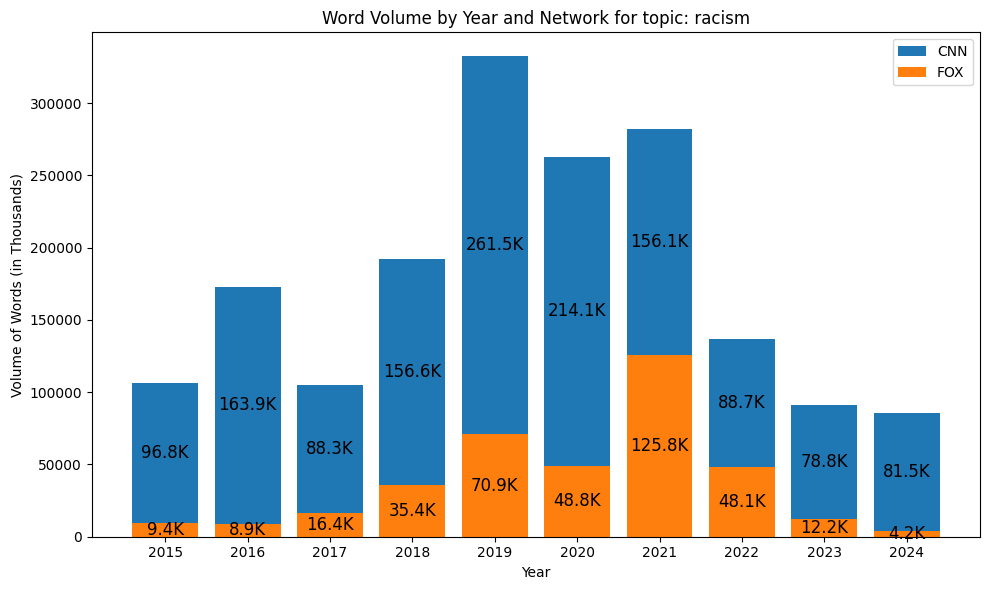

[DONE] saved figure: figures/word_volume_racism.png
[ 47740  34431  43876  51716  70965 152443 217790 101931  27972  15275] [1898590 1238674  750061  589638  703209  947673 1267260  863426  924940
  631450]


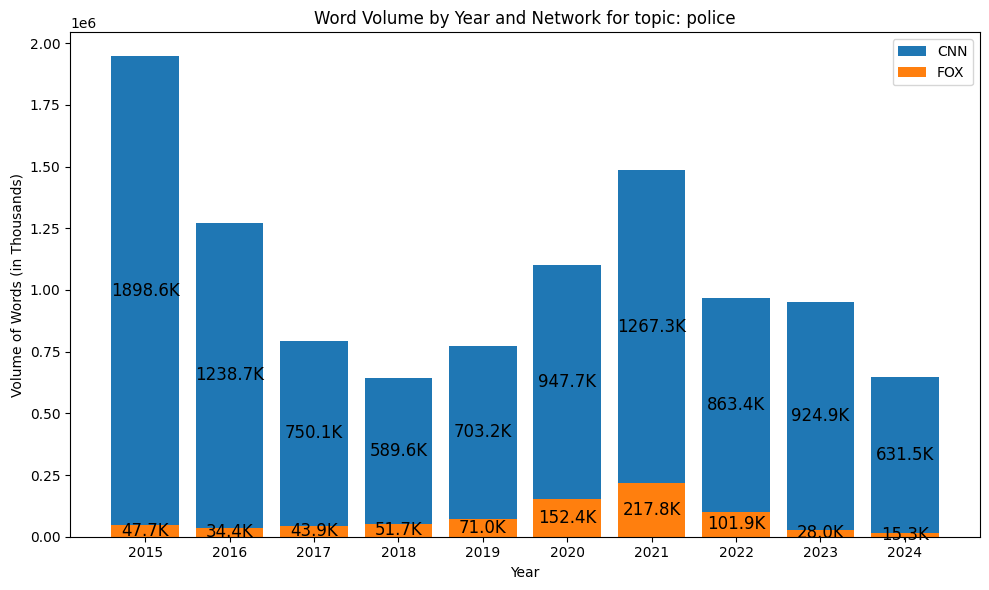

[DONE] saved figure: figures/word_volume_police.png
[ 28280  32845  59447 139085  97682  19215 101624  45656  13500  26015] [280651 432830 408574 646046 444040  84608 149089 126057 169309 460633]


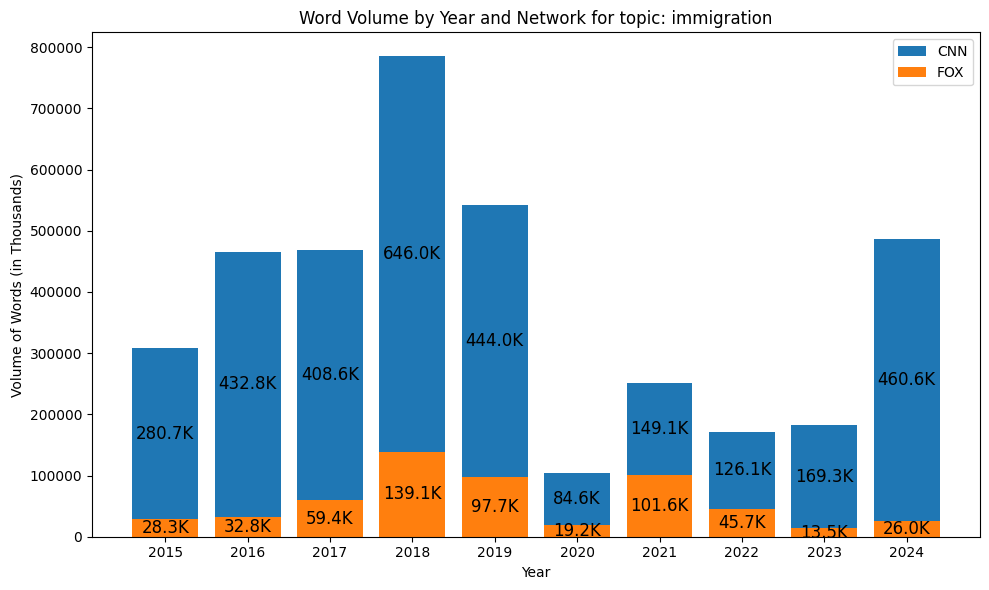

[DONE] saved figure: figures/word_volume_immigration.png


In [48]:
os.makedirs("figures", exist_ok=True)

for topic in TOPIC_KEYWORDS.keys():
    df_t = stats_df[stats_df["topic"] == topic].copy()
    if df_t.empty:
        print(f"[SKIP] no data for topic={topic}")
        continue

    pivot = df_t.pivot_table(
        index="year", columns="network", values="word_count", aggfunc="sum"
    ).fillna(0)

    years = sorted(pivot.index.tolist())

    for col in ["cnn", "fox"]:
        if col not in pivot.columns:
            pivot[col] = 0
    pivot = pivot[["cnn", "fox"]]

    cnn_vals = pivot["cnn"].values
    fox_vals = pivot["fox"].values

    x = range(len(years))

    plt.figure(figsize=(10, 6))

    bar_cnn = plt.bar(x, cnn_vals, bottom=fox_vals, label="CNN")
    bar_fox = plt.bar(x, fox_vals, label="FOX")

    print(fox_vals, cnn_vals)

    for i, (y_fox, y_cnn) in enumerate(zip(fox_vals, cnn_vals)):
        # FOX label
        if y_fox > 0:
            plt.text(
                i,
                y_fox / 2,
                format_millions(y_fox),
                ha="center",
                va="center",
                fontsize=12,
            )
        # CNN label
        if y_cnn > 0:
            plt.text(
                i,
                y_fox + y_cnn / 2,
                format_millions(y_cnn),
                ha="center",
                va="center",
                fontsize=12,
            )

    plt.xticks(x, years)
    plt.ylabel("Volume of Words (in Thousands)")
    plt.xlabel("Year")
    plt.title(f"Word Volume by Year and Network for topic: {topic}")
    plt.legend()

    plt.tight_layout()

    out_path = os.path.join("figures", f"word_volume_{topic}.png")
    plt.savefig(out_path, dpi=200)
    plt.show()

    print(f"[DONE] saved figure: {out_path}")


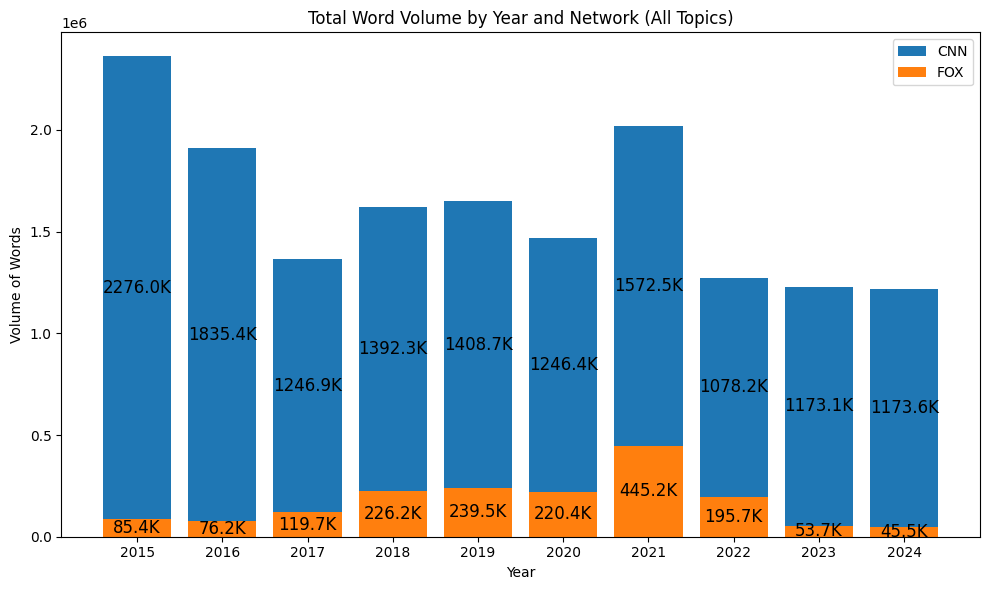

In [49]:
total_df = (
    stats_df.groupby(["year", "network"])["word_count"]
    .sum()
    .reset_index()
)

pivot_total = total_df.pivot_table(
    index="year", columns="network", values="word_count", aggfunc="sum"
).fillna(0)

years_total = sorted(pivot_total.index.tolist())

for col in ["cnn", "fox"]:
    if col not in pivot_total.columns:
        pivot_total[col] = 0
pivot_total = pivot_total[["cnn", "fox"]]

cnn_vals = pivot_total["cnn"].values
fox_vals = pivot_total["fox"].values

x = range(len(years_total))

plt.figure(figsize=(10, 6))

bar_cnn = plt.bar(x, cnn_vals, bottom=fox_vals, label="CNN")
bar_fox = plt.bar(x, fox_vals, label="FOX")

for i, (y_fox, y_cnn) in enumerate(zip(fox_vals, cnn_vals)):
    if y_fox > 0:
        plt.text(
            i,
            y_fox / 2,
            format_millions(y_fox),
            ha="center",
            va="center",
            fontsize=12,
        )
    if y_cnn > 0:
        plt.text(
            i,
            y_fox + y_cnn / 2,
            format_millions(y_cnn),
            ha="center",
            va="center",
            fontsize=12,
        )

plt.xticks(x, years_total)
plt.ylabel("Volume of Words")
plt.xlabel("Year")
plt.title("Total Word Volume by Year and Network (All Topics)")

plt.legend()

plt.tight_layout()

os.makedirs("figures", exist_ok=True)
out_path_total = os.path.join("figures", "word_volume_all_topics.png")
plt.savefig(out_path_total, dpi=200)
plt.show()

In [50]:
CLASSIFIER_ROOT = "checkpoints/classifier/roberta-base"
import json
import numpy as np


def load_fold_metrics(topic, year):
    fold_metrics = []
    for fold in range(3):
        metrics_path = os.path.join(
            CLASSIFIER_ROOT, topic, str(year), f"fold{fold}", "metrics.json"
        )
        if not os.path.isfile(metrics_path):
            print(f"[WARN] Missing metrics: {metrics_path}")
            return None
        with open(metrics_path, "r") as f:
            fold_metrics.append(json.load(f))

    avg = {}
    for key in ["eval_precision", "eval_recall", "eval_f1"]:
        avg[key[5:]] = float(np.mean([fm[key] for fm in fold_metrics]))
    return avg


records = []

for topic in TOPIC_KEYWORDS.keys():
    for year in YEARS:
        avg_metrics = load_fold_metrics(topic, year)
        if avg_metrics is None:
            continue
        records.append({
            "topic": topic,
            "year": year,
            "precision": avg_metrics["precision"],
            "recall": avg_metrics["recall"],
            "f1": avg_metrics["f1"],
        })

df = pd.DataFrame(records)
df.head()

,topic,year,precision,recall,f1
0,racism,2015,0.657236,0.420316,0.512010
1,racism,2016,0.615266,0.270270,0.374984
2,racism,2017,0.628548,0.428788,0.508518
3,racism,2018,0.693526,0.555849,0.616627
4,racism,2019,0.785816,0.597266,0.678097


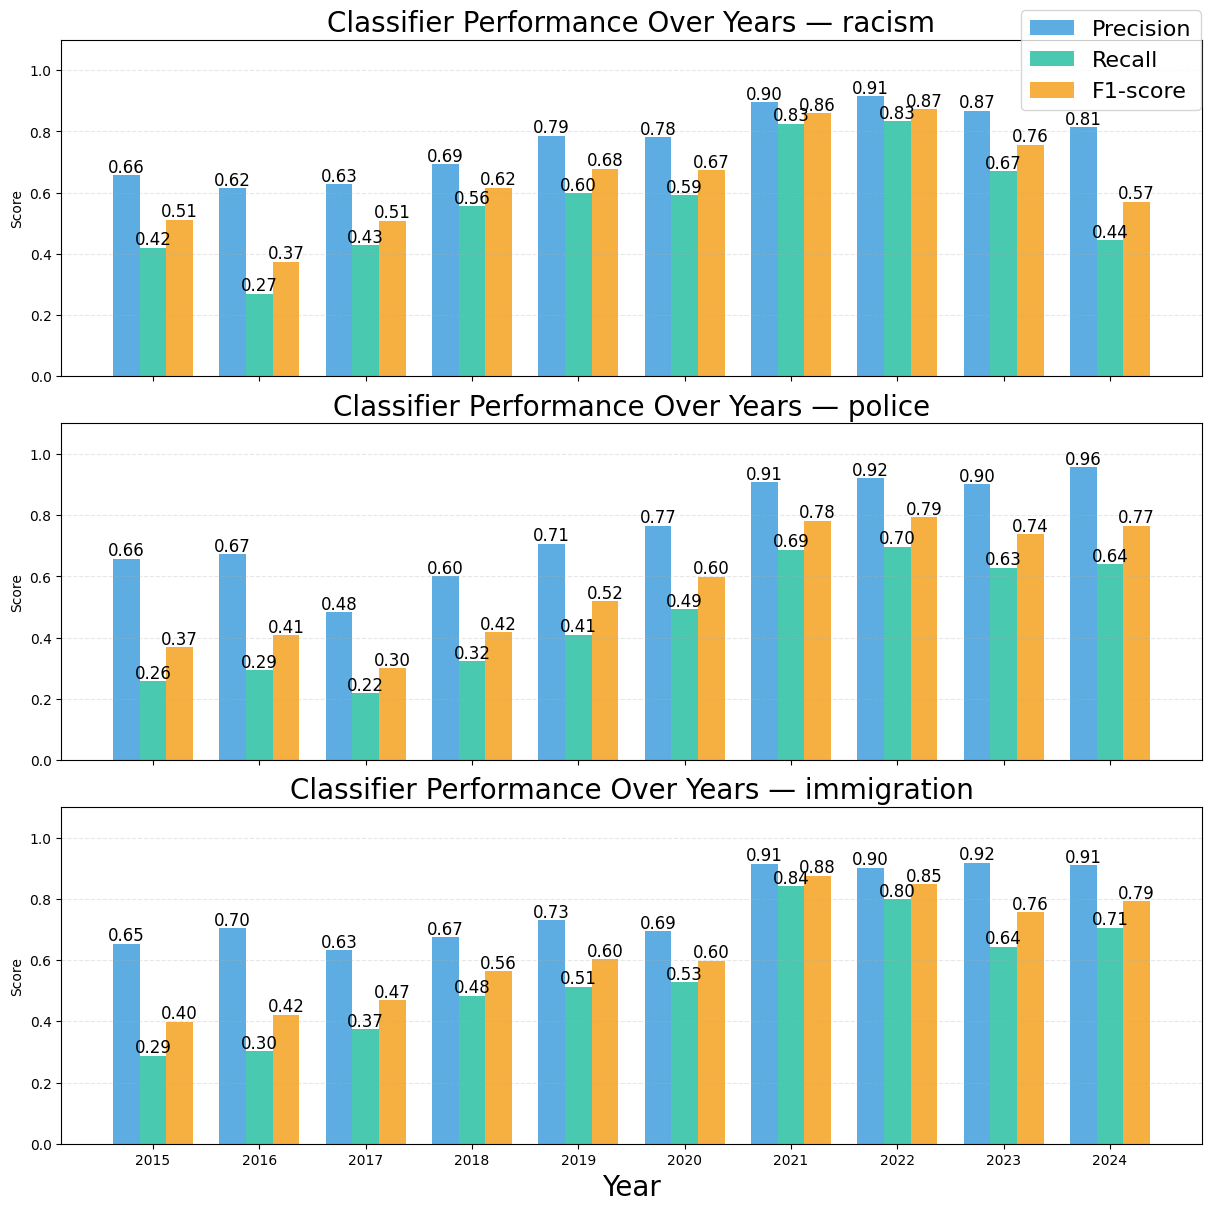

[DONE] Saved: figures/classifier_metrics/study2_all_topics_metrics_big.png


In [51]:
ordered_topics = list(TOPIC_KEYWORDS.keys())

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 12),
    sharex=True,
    constrained_layout=True
)

for ax, topic in zip(axes, ordered_topics):
    df_t = df[df["topic"] == topic].copy()
    if df_t.empty:
        ax.set_title(f"(No data for topic: {topic})")
        continue

    df_t = df_t.sort_values("year")

    years = df_t["year"].tolist()
    precision_vals = df_t["precision"].tolist()
    recall_vals = df_t["recall"].tolist()
    f1_vals = df_t["f1"].tolist()

    x = np.arange(len(years))
    bar_width = 0.25

    ax.bar(x - bar_width, precision_vals, width=bar_width, label="Precision", color="#5DADE2")
    ax.bar(x, recall_vals, width=bar_width, label="Recall", color="#48C9B0")
    ax.bar(x + bar_width, f1_vals, width=bar_width, label="F1-score", color="#F5B041")

    for idx, (p, r, f) in enumerate(zip(precision_vals, recall_vals, f1_vals)):
        ax.text(x[idx] - bar_width, p + 0.01, f"{p:.2f}", ha="center", fontsize=12)
        ax.text(x[idx], r + 0.01, f"{r:.2f}", ha="center", fontsize=12)
        ax.text(x[idx] + bar_width, f + 0.01, f"{f:.2f}", ha="center", fontsize=12)

    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Score")
    ax.set_title(f"Classifier Performance Over Years — {topic}", fontsize=20)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

axes[-1].set_xticks(x)
axes[-1].set_xticklabels(years)
axes[-1].set_xlabel("Year", fontsize=20)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=16)

os.makedirs("figures/classifier_metrics", exist_ok=True)
out_path = "figures/classifier_metrics/study2_all_topics_metrics_big.png"
plt.savefig(out_path, dpi=200)
plt.show()

print(f"[DONE] Saved: {out_path}")


## prepare tf-idf, bert, roberta

In [53]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

TOPICS = ["racism", "police", "immigration"]

BASE_DIR_TFIDF = "checkpoints/tfidf_baseline"
BASE_DIR_BERT = "checkpoints/classifier/bert-base-uncased"
BASE_DIR_ROBERTA = "checkpoints/classifier/roberta-base"

YEAR = 2021

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def load_tfidf_metrics(topic):
    path = os.path.join(BASE_DIR_TFIDF, topic, f"tfidf_metrics_{topic}_{YEAR}.json")
    return load_json(path)["metrics"]

def load_transformer_metrics(base_dir, topic):
    """Load 3 folds and compute mean eval_accuracy, eval_precision, eval_recall, eval_f1."""
    topic_dir = os.path.join(base_dir, topic, str(YEAR))
    folds = [d for d in os.listdir(topic_dir) if d.startswith("fold")]

    accs, precs, recs, f1s = [], [], [], []

    for fold in folds:
        mpath = os.path.join(topic_dir, fold, "metrics.json")
        m = load_json(mpath)

        accs.append(m["eval_accuracy"])
        precs.append(m["eval_precision"])
        recs.append(m["eval_recall"])
        f1s.append(m["eval_f1"])

    return {
        "eval_accuracy": float(np.mean(accs)),
        "eval_precision": float(np.mean(precs)),
        "eval_recall": float(np.mean(recs)),
        "eval_f1": float(np.mean(f1s)),
    }

# Load metrics for all 3 methods
results = {}
for topic in TOPICS:
    results[topic] = {
        "TF-IDF": load_tfidf_metrics(topic),
        "BERT": load_transformer_metrics(BASE_DIR_BERT, topic),
        "RoBERTa": load_transformer_metrics(BASE_DIR_ROBERTA, topic),
    }

results


{'racism': {'TF-IDF': {'eval_accuracy': 0.8360722256035708,
   'eval_precision': 0.7772128178981083,
   'eval_recall': 0.7887325835078011,
   'eval_f1': 0.7828520537295981,
   'n_samples': 9858,
   'n_splits': 3},
  'BERT': {'eval_accuracy': 0.893386082369649,
   'eval_precision': 0.8948474212491266,
   'eval_recall': 0.8109665281195207,
   'eval_f1': 0.8506363652142438},
  'RoBERTa': {'eval_accuracy': 0.8987624264556704,
   'eval_precision': 0.8960334128571891,
   'eval_recall': 0.8254241001195259,
   'eval_f1': 0.8592229671368434}},
 'police': {'TF-IDF': {'eval_accuracy': 0.9014416777460644,
   'eval_precision': 0.5008940950914417,
   'eval_recall': 0.7011502900315286,
   'eval_f1': 0.584326602404755,
   'n_samples': 58889,
   'n_splits': 3},
  'BERT': {'eval_accuracy': 0.9611302290570413,
   'eval_precision': 0.9078887842621691,
   'eval_recall': 0.6753520775463846,
   'eval_f1': 0.7744052713020165},
  'RoBERTa': {'eval_accuracy': 0.9622510041531216,
   'eval_precision': 0.908400630

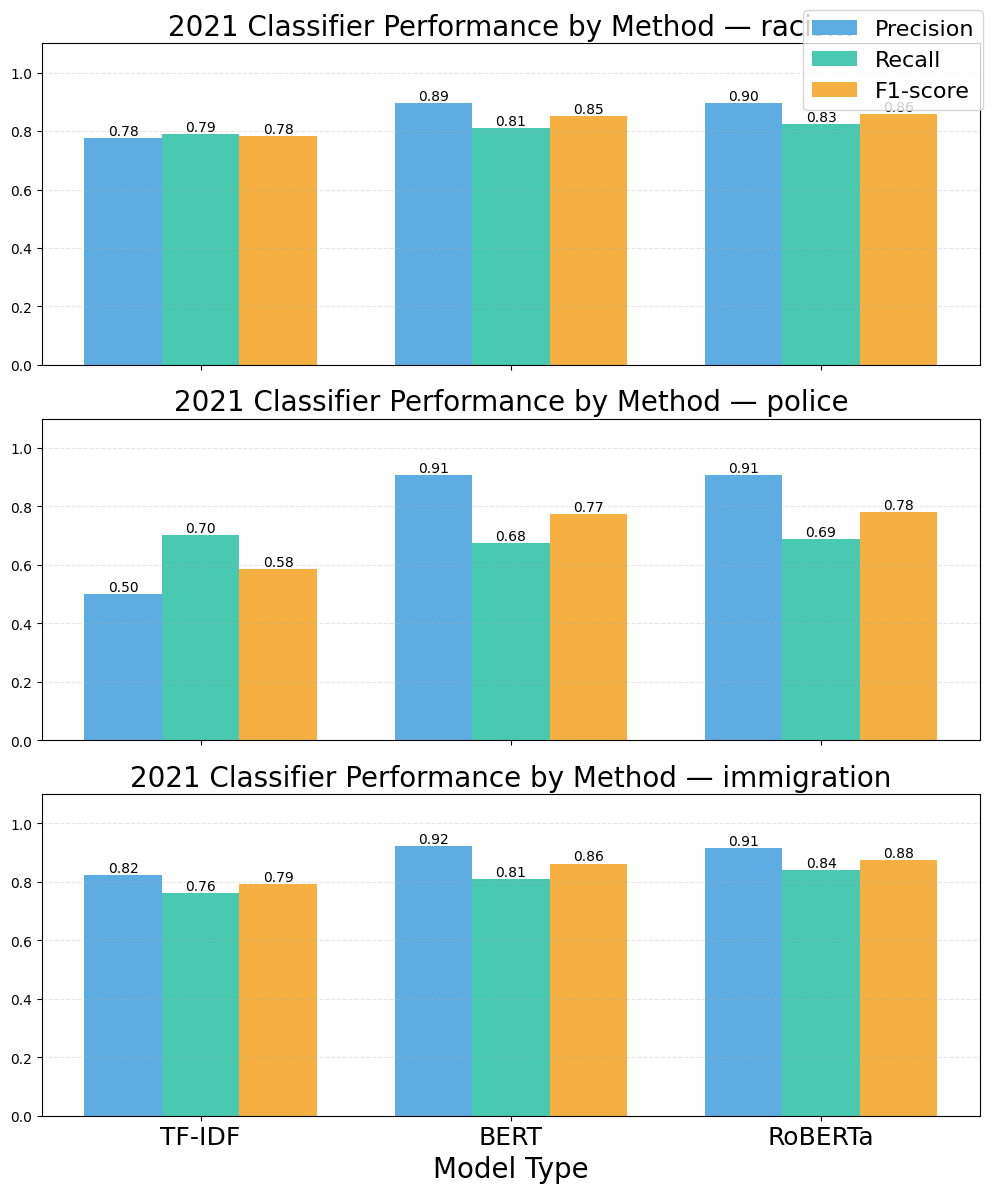

In [54]:
metrics = ["eval_precision", "eval_recall", "eval_f1"]
metric_names = ["Precision", "Recall", "F1-score"]
methods = ["TF-IDF", "BERT", "RoBERTa"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)
x = np.arange(len(methods))
bar_width = 0.25

for ax, topic in zip(axes, TOPICS):
    topic_res = results[topic]

    # Metric values (3 methods × 3 metrics)
    prec_vals = [topic_res[m]["eval_precision"] for m in methods]
    rec_vals  = [topic_res[m]["eval_recall"] for m in methods]
    f1_vals   = [topic_res[m]["eval_f1"] for m in methods]

    # Plot
    ax.bar(x - bar_width, prec_vals, width=bar_width, label="Precision", color="#5DADE2")
    ax.bar(x,            rec_vals,  width=bar_width, label="Recall",    color="#48C9B0")
    ax.bar(x + bar_width, f1_vals,  width=bar_width, label="F1",        color="#F5B041")

    # Title + labels
    ax.set_title(f"2021 Classifier Performance by Method — {topic}", fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, fontsize=18)
    ax.set_ylim(0, 1.1)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Annotate values
    for i, (p, r, f) in enumerate(zip(prec_vals, rec_vals, f1_vals)):
        ax.text(i - bar_width, p + 0.01, f"{p:.2f}", ha="center")
        ax.text(i,             r + 0.01, f"{r:.2f}", ha="center")
        ax.text(i + bar_width, f + 0.01, f"{f:.2f}", ha="center")

axes[-1].set_xlabel("Model Type", fontsize=20)
fig.legend(["Precision", "Recall", "F1-score"], loc="upper right", fontsize=16)

plt.tight_layout()
plt.savefig("figures/study2_2021_classifier.pdf", bbox_inches="tight")
plt.show()
plt.show()


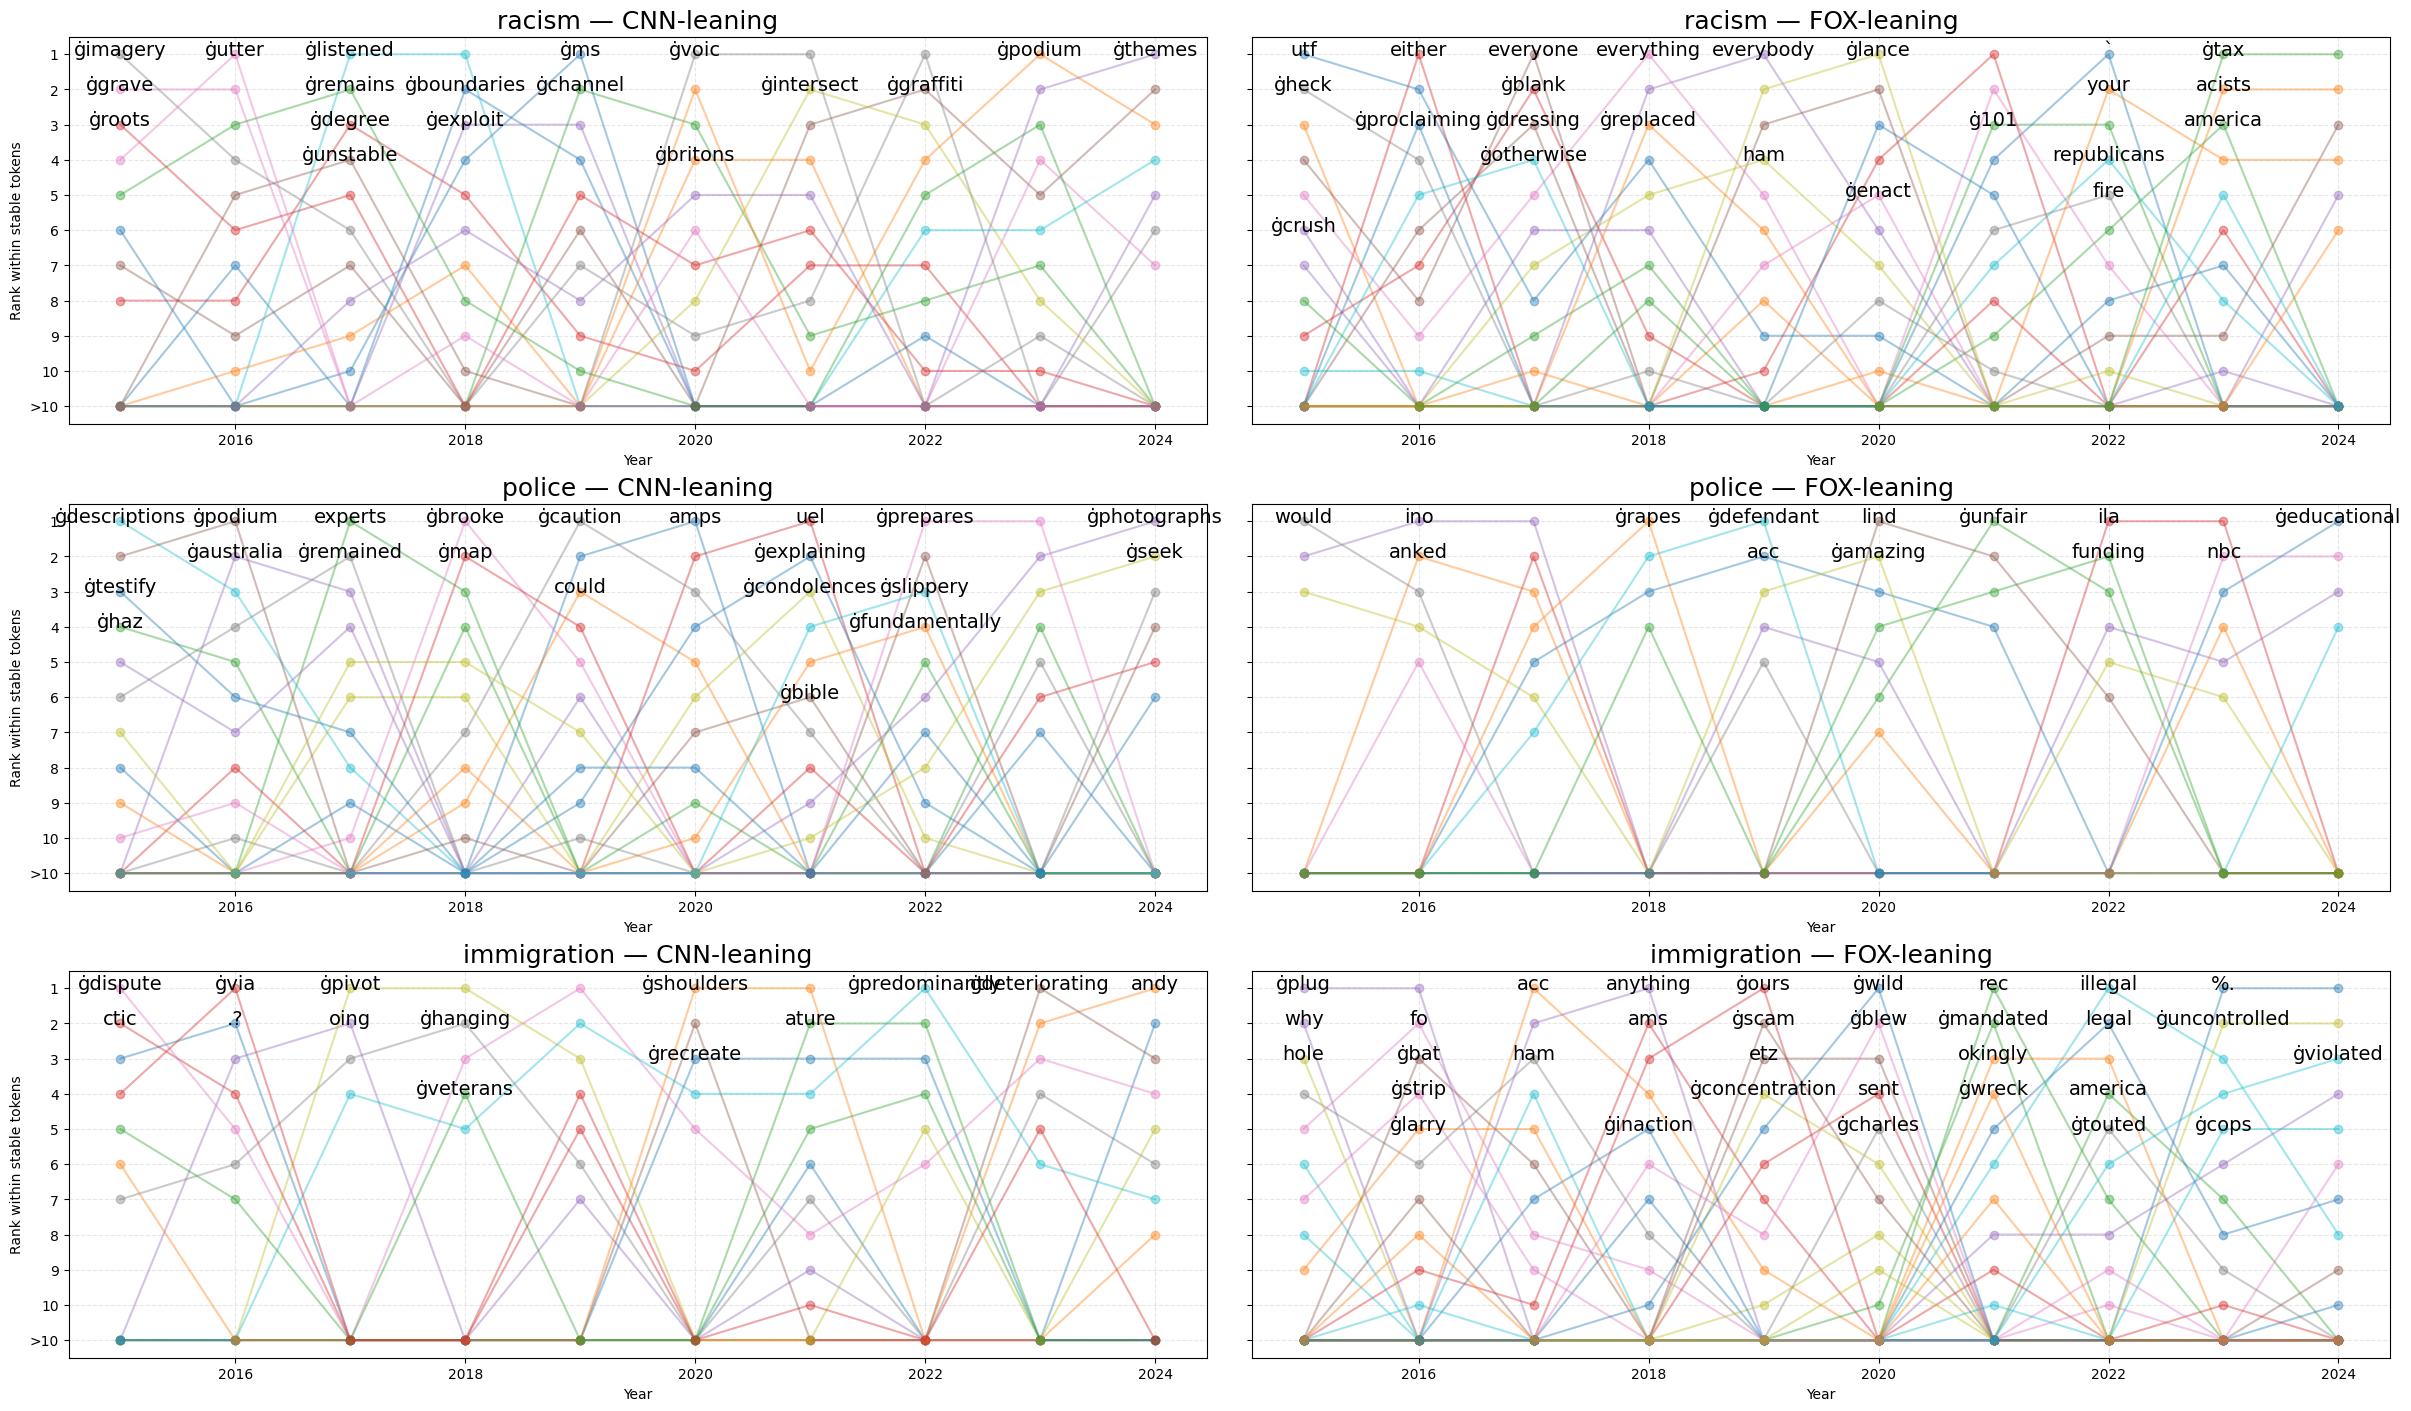

[DONE] saved figure → figures/trends/study2_topic_rank_trends.png


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ==================== 基本配置 ====================

TOPIC_KEYWORDS = {
    "racism": ["racism", "racist"],
    "police": ["police"],
    "immigration": ["immigration", "immigrant", "immigrants"],
}

YEARS = list(range(2015, 2025))          # 2015–2024
SIDES = ["cnn", "fox"]
SIDE_TITLES = {"cnn": "CNN-leaning", "fox": "FOX-leaning"}

IG_DIR = "checkpoints/ig"                # 你的 IG 输出目录
TOP_N_FOR_STABILITY = 150                # 用来判断“稳定性”的榜单长度：前30
RANK_CUTOFF_PLOT = 10                    # 绘图只关心前10，其他视为 >10
MISSING_RANK = RANK_CUTOFF_PLOT + 1      # 当年缺失或排在10名以外

# 手工黑名单（按需扩展）
EXCLUDE_TOKENS = {
    "##z", "##gb", "##oney", "##ome", "&",
    "gban", "gfin", "gdrugs", "gtik", "gparents",
    "ginteresting", "gstands", "gveery", "gsc",
}


def has_consecutive_years(year_list):
    """是否存在至少一段“连续两年”都出现的情况。"""
    ys = sorted(set(year_list))
    for i in range(len(ys) - 1):
        if ys[i + 1] == ys[i] + 1:
            return True
    return False


# ==================== 主流程：稳定 token + 每年重排 + 绘图 ====================

fig, axes = plt.subplots(
    nrows=len(TOPIC_KEYWORDS),
    ncols=len(SIDES),
    figsize=(24, 14),
    sharex=False,
    sharey=True,
    constrained_layout=True,
)

for row_idx, (topic, _) in enumerate(TOPIC_KEYWORDS.items()):
    for col_idx, side in enumerate(SIDES):
        ax = axes[row_idx][col_idx]
        title_side = SIDE_TITLES[side]

        # ---------- 1. 读取每年的 IG，取前30，统计“候选稳定 token” ----------
        per_year_top30 = {}   # year -> [token... (top30)]
        token_years = {}      # token -> [years where in top30]

        for year in YEARS:
            path = os.path.join(IG_DIR, BASE_MODEL_NAME, f"{topic}_{year}_token_attributions.csv")
            if not os.path.exists(path):
                continue

            df = pd.read_csv(path)

            # 过滤黑名单
            df = df[~df["token"].isin(EXCLUDE_TOKENS)]

            # 根据 side 方向筛选 + 排序
            if side == "cnn":
                df = df[df["avg_attr"] > 0].sort_values("avg_attr", ascending=False)
            else:  # fox
                df = df[df["avg_attr"] < 0].sort_values("avg_attr", ascending=True)

            top_df = df.head(TOP_N_FOR_STABILITY)
            tokens = top_df["token"].tolist()

            if not tokens:
                continue

            per_year_top30[year] = tokens

            for tok in tokens:
                token_years.setdefault(tok, []).append(year)

        years_available = sorted(per_year_top30.keys())
        if not years_available:
            ax.set_title(f"{topic} — {title_side} (no IG data)")
            continue

        # ---------- 2. 找出“连续两年进过前30”的稳定 token ----------
        stable_tokens = set()
        for tok, ys in token_years.items():
            if has_consecutive_years(ys):
                stable_tokens.add(tok)

        if not stable_tokens:
            ax.set_title(f"{topic} — {title_side} (no stable tokens)")
            continue

        stable_tokens = sorted(stable_tokens)

        # ---------- 3. 每年在 stable_tokens 内部重排 rank ----------
        #  rank_df[year][token] = 在“稳定词表”内部的名次（1..N），缺失/无该年记录 -> MISSING_RANK
        rank_df = pd.DataFrame(
            index=years_available,
            columns=stable_tokens,
            data=MISSING_RANK,
        )

        for year in years_available:
            path = os.path.join(IG_DIR, BASE_MODEL_NAME, f"{topic}_{year}_token_attributions.csv")
            df = pd.read_csv(path)

            df = df[~df["token"].isin(EXCLUDE_TOKENS)]

            if side == "cnn":
                df = df[df["avg_attr"] > 0].sort_values("avg_attr", ascending=False)
            else:
                df = df[df["avg_attr"] < 0].sort_values("avg_attr", ascending=True)

            # 只保留稳定词表中的 token，然后在“稳定词表”内部排名
            df = df[df["token"].isin(stable_tokens)]
            tokens_year_sorted = df["token"].tolist()

            # 给这个年的 token 按当前排序打 rank（1..）
            for r, tok in enumerate(tokens_year_sorted, start=1):
                rank_df.loc[year, tok] = r

        # ---------- 4. 绘图：只关心 rank <= 10，其它当作 noise (>10) ----------
        last_year = max(years_available)

        # 最后一年在 stable_tokens 中 rank ≤10 的 token，将进入 legend
        last_year_ranks = rank_df.loc[last_year]
        tokens_last_year_top10 = {
            tok for tok, r in last_year_ranks.items() if r <= RANK_CUTOFF_PLOT
        }

        for tok in stable_tokens:
            y_vals = rank_df[tok].values
            x_vals = years_available

            is_last_year_top = False

            # 画线
            ax.plot(
                x_vals,
                [min(r, MISSING_RANK) for r in y_vals],  # 防止超过 MISSING_RANK
                marker="o",
                linestyle="-",
                label=tok if is_last_year_top else None,
                alpha=0.9 if is_last_year_top else 0.4,
            )

            # 只在“该 token 排名最好的一年”标一次名字（且 rank <= 10 时）
            best_rank = y_vals.min()
            if best_rank <= RANK_CUTOFF_PLOT:
                best_idx = y_vals.argmin()
                best_year = x_vals[best_idx]
                ax.text(
                    best_year,
                    best_rank - 0.4,
                    tok,
                    fontsize=14,
                    ha="center",
                    va="top",
                )

        # ---------- 5. 轴 & 图例设置 ----------
        ax.invert_yaxis()
        ax.set_ylim(MISSING_RANK + 0.5, 0.5)

        ax.set_yticks(list(range(1, RANK_CUTOFF_PLOT + 1)) + [MISSING_RANK])
        ax.set_yticklabels(
            [str(i) for i in range(1, RANK_CUTOFF_PLOT + 1)] + [f">{RANK_CUTOFF_PLOT}"]
        )

        ax.set_title(f"{topic} — {title_side}", fontsize=18)
        ax.set_xlabel("Year")
        if col_idx == 0:
            ax.set_ylabel("Rank within stable tokens")

        ax.grid(True, linestyle="--", alpha=0.3)

        # 图例：只列出“最后一年在前10”的 token
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, loc="upper right", fontsize=10)

# 保存 & 展示
os.makedirs("figures/trends", exist_ok=True)
out_path = "figures/trends/study2_topic_rank_trends.png"
plt.savefig(out_path, dpi=200)
plt.show()

print(f"[DONE] saved figure → {out_path}")
